## Giriş

Bu çalışma, Borsa İstanbul 100 (BIST100) endeksine ait 04.01.2000–24.07.2020 tarihleri arasındaki geçmiş verileri kullanarak, yüksek volatilite ve ani fiyat dalgalanmalarının görüldüğü günleri önceden belirleyerek riski tahmin etmeyi amaçlamaktadır. Bu doğrultuda, teknik göstergeler aracılığıyla günlük fiyat hareketlerinin ortalamadan sapma düzeyi, göreli volatilite oranı ve günlük yüzdelik değişim analiz edilmiştir. Elde edilen bu göstergeler ışığında, belirli eşik değerlerin aşılması durumunda günler "riskli" olarak etiketlenmiş ve bu sınıflandırmalar üzerinden ertesi günün risk durumunu öngören bir makine öğrenmesi modeli geliştirilmiştir. Çalışmanın amacı; yatırım kararlarında zamanlamayı optimize edebilmek adına potansiyel riskli günlerin önceden tahmin edilmesidir.


Bu kapsamda; veri analizi,görselleştirme, özellik mühendisliği, ,LogisticRegression ve  XGBoost  makine öğrenmesi modelleri uygulanacaktır.

In [211]:
# Gerekli kütüphanelerin eklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# uyarıları gözardı et
import warnings
warnings.filterwarnings("ignore")


In [212]:
# Dataset'i Yükle
df = pd.read_excel("BIST100.xlsx")

## Exploratory Data Analysis (EDA): Veri Keşfi ve Ön Analiz

Bu veri seti BIST100 endeksinin günlük işlem verilerini içermektedir. Her bir satır bir güne aittir ve o günün açılış, kapanış, en yüksek ve en düşük değerleri ile işlem hacmini göstermektedir.

In [213]:
df.head(10) # ilk 10 veri

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,15208.799805,17639.300781,15208.799805,17512.199219,17512.199219,54538700
1,2000-01-05,17512.199219,17802.099609,16237.700195,16932.000000,16932.000000,66720900
2,2000-01-06,16932.000000,17460.699219,16086.799805,16200.000000,16200.000000,66095000
3,2000-01-07,16200.000000,16305.599609,15623.500000,15837.400391,15837.400391,25444400
4,2000-01-11,15837.400391,16388.300781,15293.200195,16347.400391,16347.400391,53618400
5,2000-01-12,16347.400391,17304.199219,16347.400391,16933.599609,16933.599609,59691700
6,2000-01-13,16933.599609,18256.800781,16933.599609,18138.199219,18138.199219,73641700
7,2000-01-14,18138.199219,19332.099609,18138.199219,19110.300781,19110.300781,67855200
8,2000-01-17,19110.300781,20617.900391,18301.300781,18458.300781,18458.300781,73244200
9,2000-01-18,18458.300781,19577.300781,18182.500000,19577.300781,19577.300781,59548700


| Sütun Adı     | Açıklama                                                                                                                               |
| ------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Date**      | İşlem günü tarihi.                                                                                                                     |
| **Open**      | Günün açılış fiyatı. (Endeksin güne başladığı değer)                                                                                   |
| **High**      | Gün içinde ulaşılan en yüksek fiyat.                                                                                                   |
| **Low**       | Gün içinde görülen en düşük fiyat.                                                                                                     |
| **Close**     | Günün kapanış fiyatı. (İşlem günü bittiğinde endeksin değeri)                                                                          |
| **Adj Close** | Düzeltmeli kapanış fiyatı (temettü ve bölünme gibi etkilerden arındırılmış değer). Bu veri `Close` ile aynıysa düzeltme yapılmamıştır. |
| **Volume**    | O gün BIST100 endeksi bazında gerçekleşen toplam işlem hacmi (adet olarak değil, endeks bazlı).                                        |


### Veri Setinden ilk 10 veriyi getir

In [214]:
df.tail(10) # son 10 veri

,Date,Open,High,Low,Close,Adj Close,Volume
5137,2020-07-10,115450.898438,115450.898438,112829.398438,114808.601562,114808.601562,5028187200
5138,2020-07-13,116262.101562,118398.703125,116125.500000,118398.703125,118398.703125,4458093300
5139,2020-07-14,118113.796875,118657.601562,117002.203125,117741.101562,117741.101562,5171757800
5140,2020-07-16,118734.796875,119451.296875,118684.796875,118807.500000,118807.500000,3856903200
5141,2020-07-17,118864.601562,119161.101562,118360.601562,118786.101562,118786.101562,2834136600
5142,2020-07-20,118844.500000,119747.296875,118582.796875,119280.898438,119280.898438,3549002100
5143,2020-07-21,120170.898438,120585.601562,117160.500000,118042.000000,118042.000000,4735656100
5144,2020-07-22,118815.601562,119371.601562,117535.601562,118079.898438,118079.898438,5163053900
5145,2020-07-23,118714.000000,119672.398438,118585.398438,119031.203125,119031.203125,3508334900
5146,2020-07-24,118500.796875,119201.601562,118220.796875,119201.601562,119201.601562,3165933000


### Eksik veri kontrolü

In [215]:
df.isnull().sum() # kolonlardaki eksik veri sayısının toplamı

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

#### Tüm sayısal sütunlar için genel istatistikler

In [216]:
df.describe() # Temel istatistik bilgiler

,Date,Open,High,Low,Close,Adj Close,Volume
count,5147,5147.000000,5147.000000,5147.000000,5147.000000,5147.000000,5.147000e+03
mean,2010-04-19 08:21:04.581309440,54426.460624,54910.784548,53861.037433,54388.448239,54388.448239,5.718940e+08
min,2000-01-04 00:00:00,7159.700195,7477.399902,6796.899902,7159.700195,7159.700195,4.329000e+05
25%,2005-03-09 12:00:00,24433.050781,24699.850586,24057.849609,24428.150391,24428.150391,2.318878e+08
50%,2010-04-22 00:00:00,54730.699219,55175.800781,53959.898438,54719.000000,54719.000000,4.623890e+08
75%,2015-06-06 12:00:00,79040.851562,79614.000000,78416.699219,78975.500000,78975.500000,7.219930e+08
max,2020-07-24 00:00:00,124215.898438,124536.601562,122368.703125,123556.101562,123556.101562,7.668058e+09
std,NaN,31860.547211,32025.808602,31642.109607,31807.239635,31807.239635,5.517501e+08


| İstatistik          | Açılış Fiyatı       | Gün İçi En Yüksek Fiyat       | 	Gün İçi En Düşük Fiyat        | 	Kapanış Fiyatı      |Düzeltilmiş Kapanış Fiyatı| 	İşlem Hacmi (Adet)        |
| ------------------- | ---------- | ---------- | ---------- | ---------- | ---------- | ------------- |
| **Gözlem Sayısı**   | 5,147      | 5,147      | 5,147      | 5,147      | 5,147      | 5,147         |
| **Ortalama**        | 54,426.46  | 54,910.78  | 53,861.04  | 54,388.45  | 54,388.45  | 571,894,000   |
| **Standart Sapma**  | 31,860.55  | 32,025.81  | 31,642.11  | 31,807.24  | 31,807.24  | 551,750,100   |
| **Minimum**         | 7,159.70   | 7,477.40   | 6,796.90   | 7,159.70   | 7,159.70   | 432,900       |
| **1. Çeyrek (25%)** | 24,433.05  | 24,699.85  | 24,057.85  | 24,428.15  | 24,428.15  | 231,887,800   |
| **Medyan (50%)**    | 54,730.70  | 55,175.80  | 53,959.90  | 54,719.00  | 54,719.00  | 462,389,000   |
| **3. Çeyrek (75%)** | 79,040.85  | 79,614.00  | 78,416.70  | 78,975.50  | 78,975.50  | 721,993,000   |
| **Maksimum**        | 124,215.90 | 124,536.60 | 122,368.70 | 123,556.10 | 123,556.10 | 7,668,058,000 |

* Tarih  04.01.2000-24.07.2020
* Ort kapanış değeri 54 binlerdeyken standart sapma 32 binler ciavarında ve Standart sapma oranı yaklaşık %58 civarındadır. Bu sebeple yatrıımcılar için yüksek risk ve yüksek kazanç anlamına gelmektedir.(Volatilite Yüksek) 
* İşlem hacminde çok yüksek zirveler görülüyor(* Ortalama hacim: 571 milyon ve Maksimum hacim: 7.6 milyar). Bu durum, dönemsel olarak ani piyasa tepkilerinin veya yoğun alım-satım faaliyetlerinin yaşandığını düşündürebilir (örneğin kriz dönemleri).
* Fiyatların medyan ve ort değerleri birbirinbe oldukça yakın. Bu veri dağılımının nispeten dengeli olduğunu gösterir.
* Son olarak çeyreklik dağılıma bakıldığında(%25-%75), endeksin zaman içinde yukarı yönlü ciddi bir büyüme kaydettiği ve bu büyümenin veriye dağılmış olduğu görülüyor.

Veri seti zaman içinde belirgin bir büyüme trendi(min, max ve mean değerlerin yola çıkarak), artan işlem hacmi ve yüksek volatilite barındırmaktadır. Bu durum, özellikle risk tahminleme ve volatilite analizi gibi makine öğrenmesi uygulamaları için uygun olduğu söylenebilir.

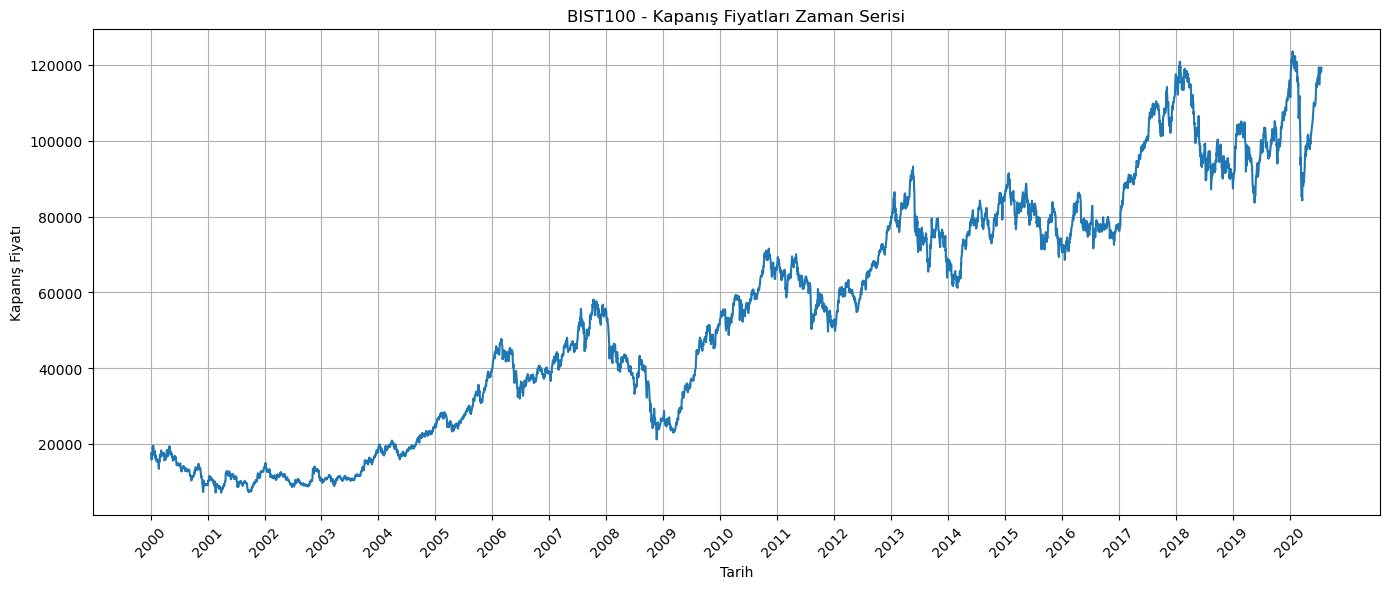

In [217]:
# Yıl bazlı etiket için sadece verideki gerçek yılları kullan
df["Date"] = pd.to_datetime(df["Date"]) 
df["Year"] = df["Date"].dt.year
unique_years = sorted(df["Year"].unique())
tick_dates = pd.to_datetime([f"{year}-01-01" for year in unique_years])  # sadece mevcut veriye göre

plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Close"])
plt.title("BIST100 - Kapanış Fiyatları Zaman Serisi")
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı")

# X ekseni için sadece mevcut veri aralığındaki yıl başları
plt.xticks(ticks=tick_dates, labels=unique_years, rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

* Genel olarak yukarı yönlü bir trend hâkim. Bu da BIST100’ün zamanla nominal olarak büyüdüğünü gösteriyor.
* 2001–2002: Ekonomik kriz kaynaklı sert düşüş (dot-com + Türkiye iç krizi)
* 2008 küresel finansal krizi döneminde ciddi bir düşüş yaşanmış. Ardından toparlanma süreci göze çarpıyor.
* 2013–2016: Yatay seyir ve belirsizlik dönemleri (iç siyasi/ekonomik gelişmeler)
* 2019-2020 yüksek enflasyon ve kur etkisiyle endeksin nominal değeri artmıştır denilebilir.

### "BIST100 - Günlük Yüzde Değişim"

#### Bu grafik, hangi dönemlerde yüksek oynaklık yaşandığını gösterir (örneğin 2008 krizi, pandemi dönemi gibi).

`PctChange_t = ((Close_t - Close_{t-1}) / Close_{t-1}) * 100`

Close_t: t günündeki kapanış fiyatı

Close_{t-1}: bir önceki günün kapanış fiyatı

Bu Formül;

Bugünkü kapanış fiyatı ile dünkü kapanış fiyatı arasındaki farkı, dünkü kapanış fiyatına bölmek, sonra da 100 ile çarparak yüzde olarak ifade etmek.


df["PctChange"] => Endeksin kapanış fiyatındaki günlük yüzde değişimi hesaplar. pct_change() fonksiyonu, her bir günün kapanış fiyatını bir önceki günle karşılaştırarak oransal değişimi verir. Bu değer 100 ile çarpılarak yüzde formatına dönüştürülür. Bu oran, fiyatın ne kadar hızlı ve sert değiştiğini göstermek için temel bir göstergedir.

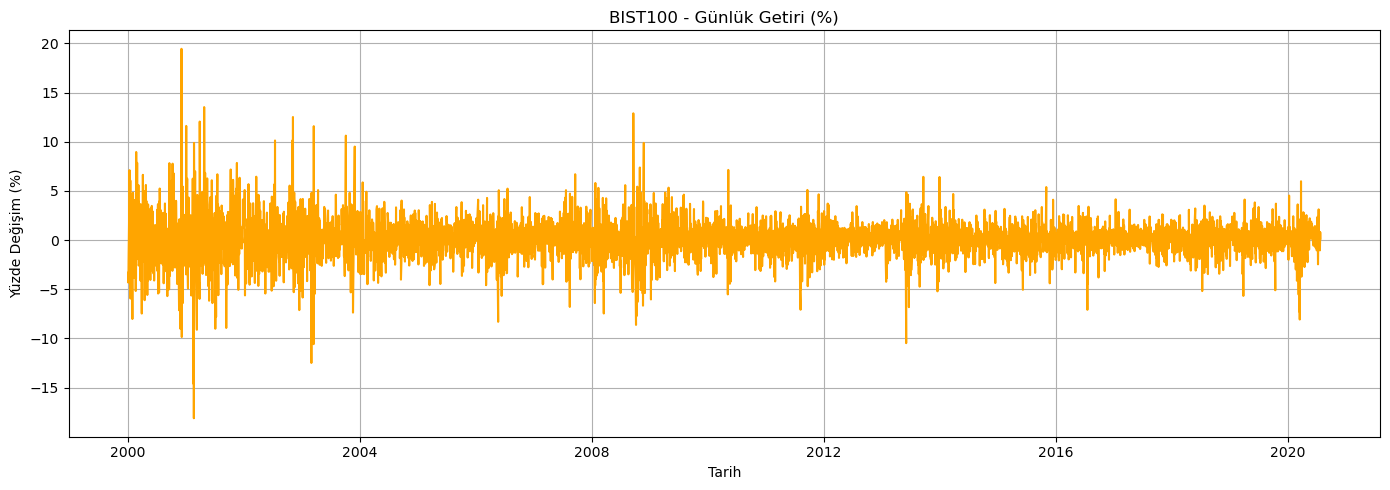

In [218]:
df["PctChange"] = df["Close"].pct_change() * 100  # % olarak değişim

plt.figure(figsize=(14, 5))
plt.plot(df["Date"],df["PctChange"], color="orange")
plt.title("BIST100 - Günlük Getiri (%)")
plt.xlabel("Tarih")
plt.ylabel("Yüzde Değişim (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


### BIST100 Kapanış Fiyatlarının Dağılımı (Boxplot)

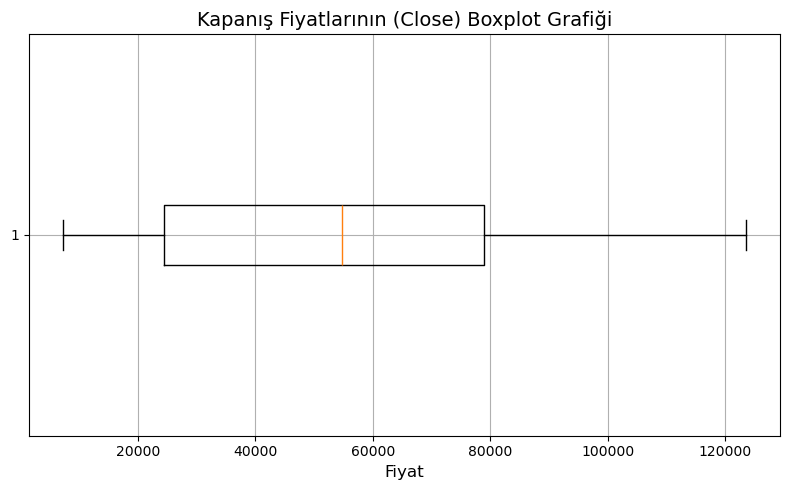

In [219]:
plt.figure(figsize=(8, 5))
plt.boxplot(df["Close"], vert=False)
plt.title("Kapanış Fiyatlarının (Close) Boxplot Grafiği", fontsize=14)
plt.xlabel("Fiyat", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

### Yıllara Göre Ortalama Kapanış Fiyatı(BIST100)

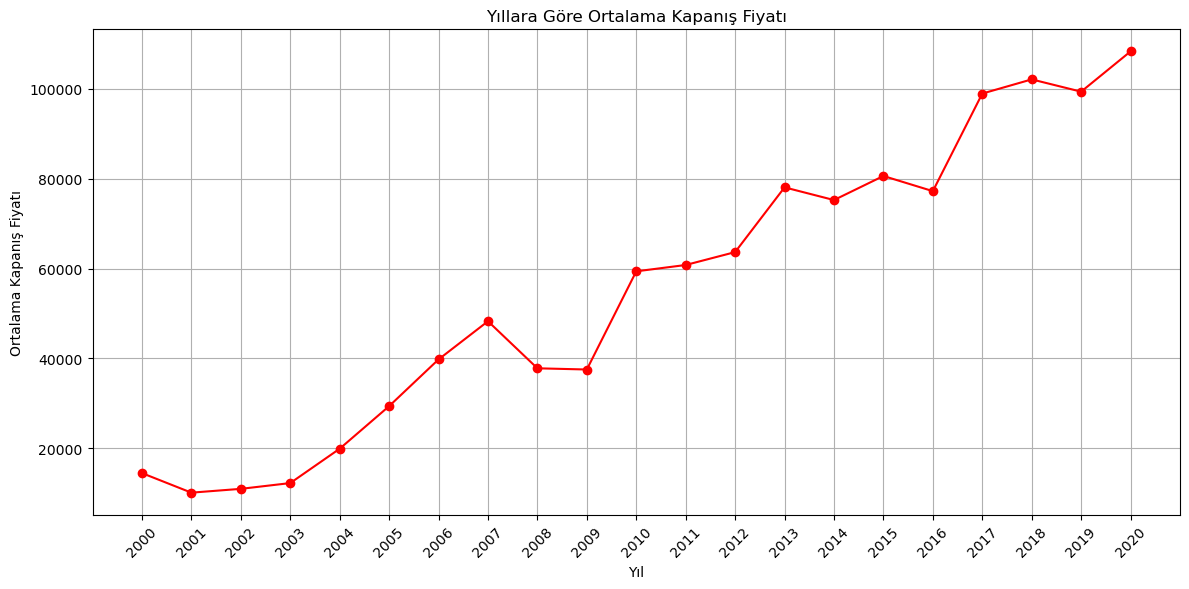

In [220]:
# Yıllık ortalama kapanış fiyatını hesapla
yearly_avg_close = df.groupby("Year")["Close"].mean().reset_index()

# Grafik
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg_close["Year"], yearly_avg_close["Close"], marker='o', color='red')

# Başlık ve eksenler
plt.title("Yıllara Göre Ortalama Kapanış Fiyatı")
plt.xlabel("Yıl")
plt.ylabel("Ortalama Kapanış Fiyatı")

# Tüm yılları x eksenine yaz
plt.xticks(yearly_avg_close["Year"], rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

* Grafik boyunca iniş-çıkışlar gözlemlenebilir; bunlar ekonomik dalgalanmalara (krizler, büyüme dönemleri vs.) karşılık gelir.

* 2000'li yılların başında fiyatlar 10.000 – 20.000 bandında seyrederken, 2020’ye yaklaştıkça kapanış fiyatlarında belirgin bir artış görülmektedir.

* Bu yükseliş, uzun vadeli artan trendi ve zamanla değer kazanımını açıkça göstermektedir.

* Ayrıca bazı keskin düşüşler de dikkat çekmektedir.
    + Bu düşüşler büyük olasılıkla 2001 krizi, 2008 küresel kriz ve benzeri ekonomik olaylara işaret eder.

* 2010 sonrası dönemde genel bir artış görülmekte, 2017 sonrası hızlı yükseliş dikkat çekmektedir.
* Kapanış fiyatları düzenli olarak artmış.



<Figure size 7500x3000 with 0 Axes>

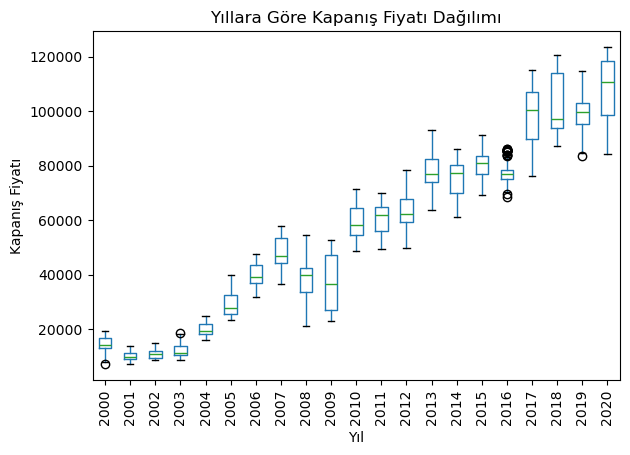

In [221]:
df["Year"] = df["Date"].dt.year  # Yıl bilgisini çıkar

plt.figure(figsize=(15, 6), dpi=500)
df.boxplot(column="Close", by="Year", grid=False, rot=90)
plt.title("Yıllara Göre Kapanış Fiyatı Dağılımı")
plt.suptitle("") 
plt.xlabel("Yıl")
plt.ylabel("Kapanış Fiyatı")
plt.tight_layout()
plt.show()

#### 2000-2008 
* 2008 krizi sonrası (özellikle 2009) geniş kutular dikkat çekiyor → fiyat dalgalanmaları fazla olmuş.
* 2000–2004 arası: Dar kutular → düşük volatilite
* 2008–2009 ve 2016–2019: Geniş kutular ve uzun whisker'lar → yüksek volatilite

#### 2016–2020 arası:
* Outlier sayısı artmış → uç değerler görülüyor özellikle 2017 yılında.
* 2019–2020 kutuları çok yukarıda → ciddi değer artışı yaşanmış. Piyasanın yüksek oynaklık gösterdiğine işaret ediyor

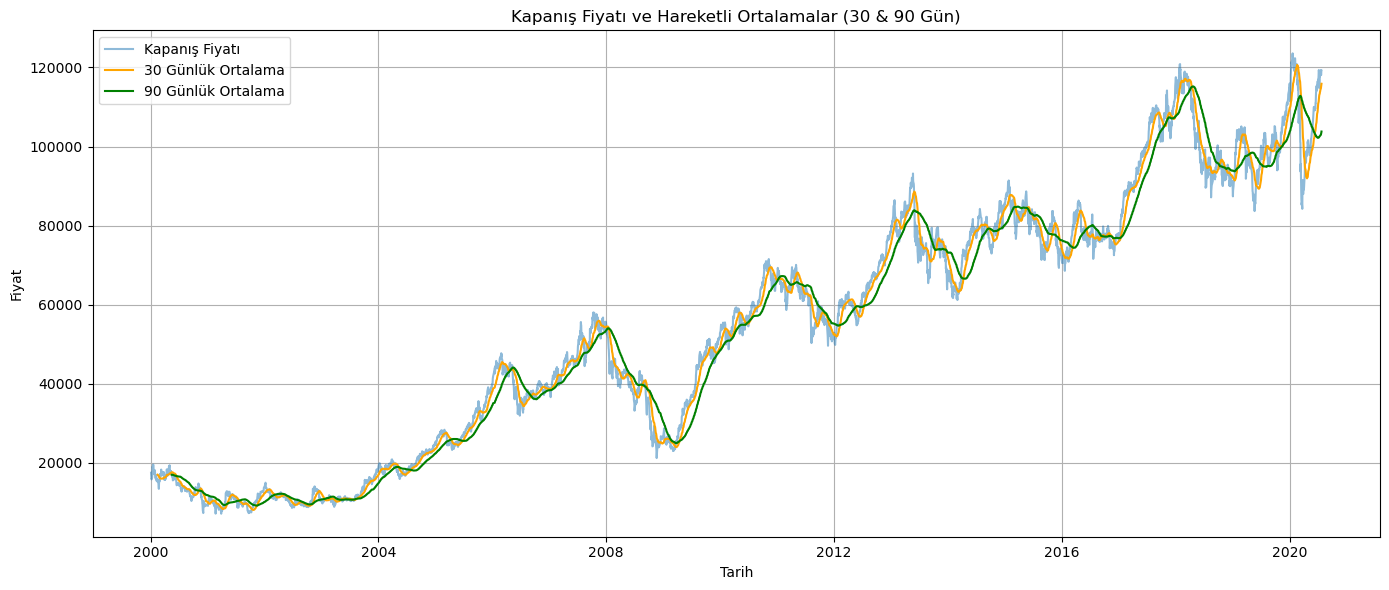

In [222]:
df = df.sort_values("Date")

# Hareketli ortalamaları hesapla
df["MA_30"] = df["Close"].rolling(window=30).mean()
df["MA_90"] = df["Close"].rolling(window=90).mean()

# Grafik çiz
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Close"], label="Kapanış Fiyatı", alpha=0.5)
plt.plot(df["Date"], df["MA_30"], label="30 Günlük Ortalama", color="orange")
plt.plot(df["Date"], df["MA_90"], label="90 Günlük Ortalama", color="green")
plt.title("Kapanış Fiyatı ve Hareketli Ortalamalar (30 & 90 Gün)")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* 30 Günlük Hareketli Ortalama (Turuncu Çizgi): Kısa vadeli eğilimi gösterir. Fiyattaki ani değişimlere daha hızlı tepki verir.
* 90 Günlük Hareketli Ortalama (Yeşil Çizgi): Uzun vadeli eğilimi gösterir. Fiyattaki dalgalanmalardan daha az etkilenir, daha pürüzsüz bir çizgi çizer.
* Hareketli ortalamalarda da 20 yıllık süreçte yükselen bir trend izlediği gözükmektedir. 2010 dan sonra bu artı yön ivme kazanmıştır.
* Bu süreçte zaman zaman düşüşlerde yaşanmış dalgalı bir seyir izlenmiştir.
- NOT: Kapanış fiyatı her iki hareketli ortalamanın da altındayken veya altına düştüğünde bir düşüş sinyali olarak yorumlanır.
30 günlük hareketli ortalamanın 90 günlük hareketli ortalamayı aşağı doğru kesmesi (ölüm kesişimi) genellikle bir düşüş trendinin başlangıcı olarak kabul edilir. Grafikte 2008 krizi döneminde ve diğer bazı düşüş dönemlerinde bu tür kesişimler dikkat çekiyor.

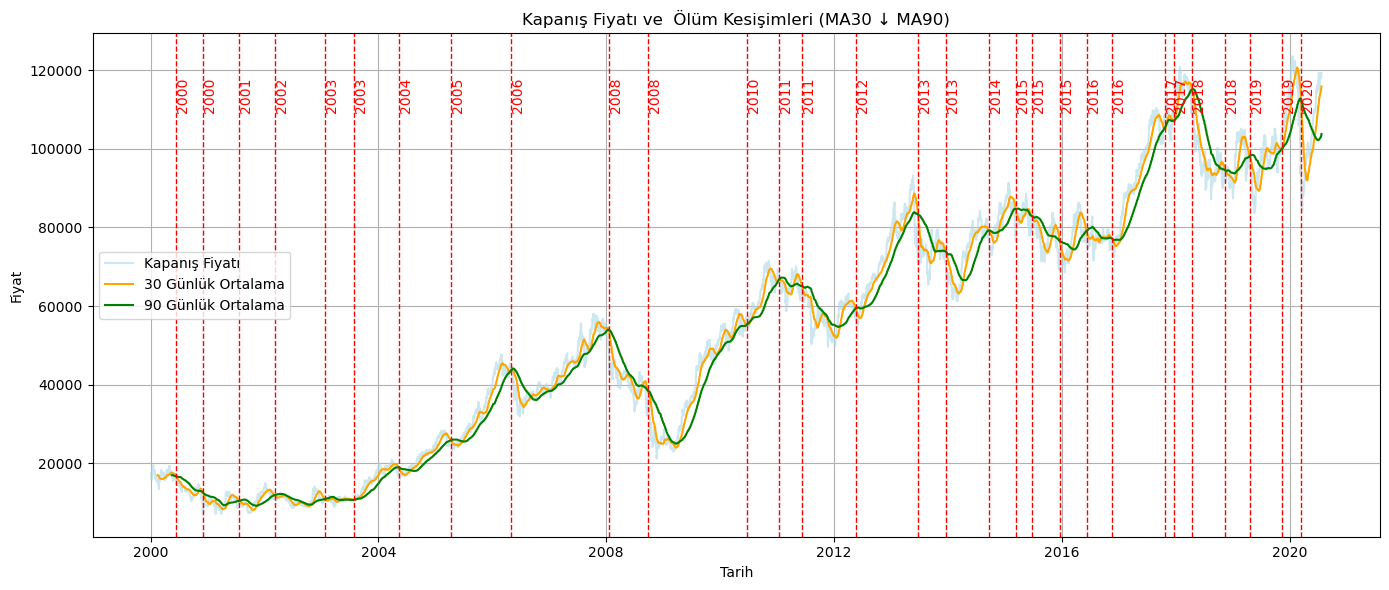

In [223]:
# "ölüm kesişimi" noktalarını bul (MA30 ↓ MA90)
df["Death_Cross"] = (df["MA_30"].shift(1) > df["MA_90"].shift(1)) & (df["MA_30"] <= df["MA_90"])

# Bu tarihler listelensin
death_cross_dates = df[df["Death_Cross"]]["Date"].tolist()

# Grafik çiz
plt.figure(figsize=(14, 6))
plt.plot(df["Date"], df["Close"], label="Kapanış Fiyatı", color='lightblue', alpha=0.6)
plt.plot(df["Date"], df["MA_30"], label="30 Günlük Ortalama", color="orange")
plt.plot(df["Date"], df["MA_90"], label="90 Günlük Ortalama", color="green")

# Ölüm kesişimi noktalarına kırmızı çizgi çek
for date in death_cross_dates:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)
    plt.text(date, df["Close"].max()*0.89, f"{date.year}", rotation=90, color='red', fontsize=10)

# Başlık ve eksenler
plt.title("Kapanış Fiyatı ve  Ölüm Kesişimleri (MA30 ↓ MA90)")
plt.xlabel("Tarih")
plt.ylabel("Fiyat")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- "Ölüm Kesişimleri("Death Cross)": Kırmızı dikey çizgilerle işaretlenen yerler, kısa vadeli ortalamanın (turuncu) uzun vadeli ortalamayı (yeşil) aşağı kestiği noktalar. Bunlar genellikle gelecekteki düşüş trendlerinin bir sinyali olarak kabul edilmkte. Grafikteki düşüşler uyumlu görünüyorlar (örn. 2008 krizi, 2018 sonu).

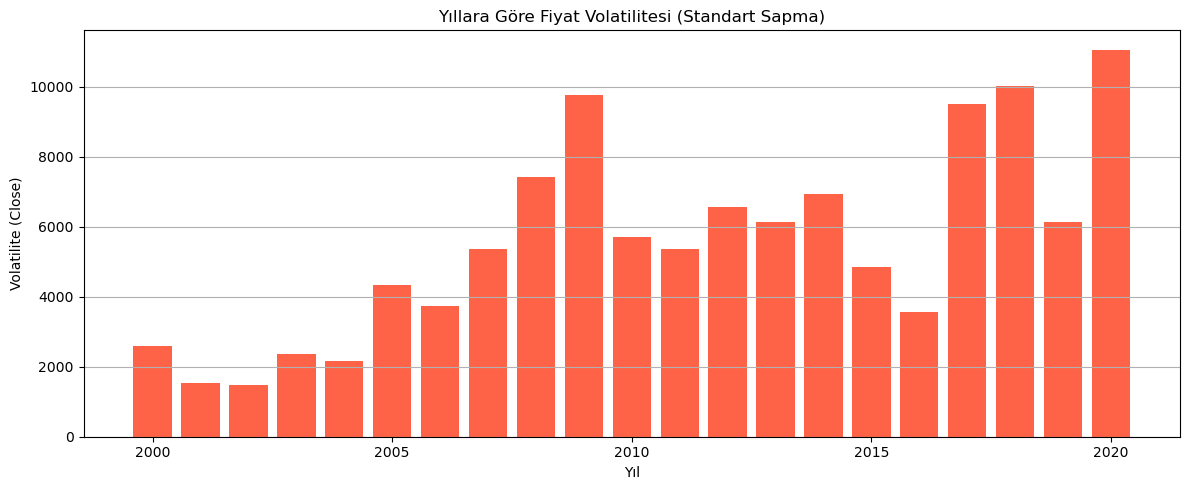

In [224]:
yearly_volatility = df.groupby("Year")["Close"].std().reset_index()

# Grafik çiz
plt.figure(figsize=(12, 5))
plt.bar(yearly_volatility["Year"], yearly_volatility["Close"], color="tomato")
plt.title("Yıllara Göre Fiyat Volatilitesi (Standart Sapma)")
plt.xlabel("Yıl")
plt.ylabel("Volatilite (Close)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Grafik Yorumu
* 2000’li yılların başında piyasa volatilitesi (değişkenliği) daha düşük.
* 2004-2008 döneminde volatilite belirgin şekilde artmış. Özellikle 2008’de küresel krizle birlikte fiyat oynaklığı zirve yapmaktadır. Grafik, bu dönemde piyasaların sert dalgalandığını açıkça gösteriyor.
* 2009-2012: 2008 krizinin ardından volatilite azalsa da, 2000'li yılların başına göre hala yüksek. 2011'de artış görülürken, 2012'de hafif bir düşüş yaşandı.
* 2013-2016: Volatilite düşüş eğilimine girdi; 2016’da piyasa görece sakin ve öngörülebilir bir hale geldi.
* 2017-2020: Volatilite yeniden yükseldi. 2017, 2018 ve özellikle 2020’de, kriz dönemini aşan seviyelere ulaşıldı. 2020'deki artış büyük ölçüde COVID-19’un etkisine bağlanabilir.

# Features(Öz Nitelik, Özellik) Ekle

In [225]:
df = pd.read_excel("BIST100.xlsx") # dataseti tekrar yükle

In [226]:
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,15208.799805,17639.300781,15208.799805,17512.199219,17512.199219,54538700
1,2000-01-05,17512.199219,17802.099609,16237.700195,16932.000000,16932.000000,66720900


In [227]:
df["Ort10g"] = df["Close"].rolling(window=10).mean() # Ortalama 10 günlük değer
df["Std10g"] = df["Close"].rolling(window=10).std() # 10 günlük değer standart sapması
df["MutlakFark"] = (df["Close"] - df["Ort10g"]).abs() # Mutlak Fark kolonunu ekledik

# Yukardaki değerlerden yeni özellikler çıkartıp "risk" faktörünü belirlemek isteriz.

df["PctChange"] = df["Close"].pct_change() * 100      # Günlük yüzdelik değişim
df["VolatiliteOranı"] = df["Std10g"] / df["Ort10g"]   # Volatilitenin fiyata oranı
df["SapmaOranı"] = df["MutlakFark"] / df["Std10g"]    # Sapma / sapma eşiği


In [228]:
df.iloc[2575:2585] # Eklenen değerleri görelim 

,Date,Open,High,Low,Close,Adj Close,Volume,Ort10g,Std10g,MutlakFark,PctChange,VolatiliteOranı,SapmaOranı
2575,2010-04-27,58972.699219,59009.800781,58017.699219,58217.398438,58217.398438,566053000,58577.329688,455.511378,359.931250,-1.398638,0.007776,0.790170
2576,2010-04-28,57310.898438,58069.800781,56867.000000,57933.101562,57933.101562,713595000,58563.100000,474.749712,629.998437,-0.488337,0.008107,1.327012
2577,2010-04-29,58160.601562,58760.101562,57899.398438,58702.800781,58702.800781,564686000,58500.350000,397.216600,202.450781,1.328600,0.006790,0.509674
2578,2010-04-30,58840.300781,59285.199219,57988.800781,58959.101562,58959.101562,618498000,58490.750000,383.233515,468.351562,0.436607,0.006552,1.222105
2579,2010-05-03,58794.398438,58996.898438,58305.300781,58400.199219,58400.199219,573054000,58508.419922,373.491925,108.220703,-0.947949,0.006384,0.289754
2580,2010-05-04,58565.300781,58861.101562,56862.199219,57341.000000,57341.000000,692899000,58427.219922,519.195694,1086.219922,-1.813691,0.008886,2.092120
2581,2010-05-05,57259.699219,57587.300781,56112.199219,56441.101562,56441.101562,664947000,58182.719922,786.155822,1741.618359,-1.569380,0.013512,2.215360
2582,2010-05-06,56226.101562,56809.000000,55595.398438,55763.601562,55763.601562,524133000,57913.990234,1086.299849,2150.388672,-1.200366,0.018757,1.979554
2583,2010-05-07,53804.898438,54381.800781,52570.500000,52687.000000,52687.000000,885778000,57348.850391,1959.815763,4661.850391,-5.517222,0.034174,2.378719
2584,2010-05-10,54956.199219,56585.898438,54956.199219,56448.000000,56448.000000,716637000,57089.330469,1880.753631,641.330469,7.138383,0.032944,0.340997


## Yöntem

Makine öğrenmesi modelinin daha anlamlı sonuçlar üretebilmesi için, ham fiyat verileri üzerinden çeşitli türetilmiş öznitelikler oluşturulmuştur. Bu öznitelikler aşağıdaki gibidir:

- **Ort10g**: 10 günlük kapanış fiyatlarının hareketli ortalamasıdır. Kısa vadeli fiyat trendini belirlemek amacıyla kullanılır.
- **Std10g**: 10 günlük kapanış fiyatlarının standart sapmasıdır. Bu değişken, ilgili periyottaki fiyat oynaklığını temsil eder.
- **MutlakFark**: Kapanış fiyatı ile 10 günlük ortalama arasındaki mutlak farktır. Kısa vadeli sapmaların şiddetini ölçer.
- **PctChange**: Kapanış fiyatının bir önceki güne göre yüzde değişimi. Günlük getiri oranı olarak yorumlanabilir.
- **VolatiliteOranı**: 10 günlük standart sapmanın ortalamaya oranıdır. Göreceli volatilite göstergesi olarak kullanılır.
- **SapmaOranı**: Mutlak farkın standart sapmaya oranıdır. Bu oran, fiyatın istatistiksel normlara göre ne kadar sapma gösterdiğini ifade eder.

Bu özniteliklerle oluşturulan veri seti, modelin fiyat hareketlerini daha iyi öğrenebilmesini sağlamıştır. Eksik veriler temizlenmiş ve model eğitimi için uygun formatta hazırlanmıştır.

Model olarak `LogisticRegression` ve`XGBoostClassifier` kullanılmış, veri seti %70 eğitim ve %30 test olarak ayrılmıştır. Değerlendirme metrikleri arasında **accuracy**, **precision**, **recall**, **F1-score** ve özellikle **ROC-AUC** yer almaktadır. 


In [229]:
df["Risk"] = (
    (df["SapmaOranı"] > 1) &                    # Ortalama sapmanın üstünde
    (df["VolatiliteOranı"] > 0.015) &           # Volatilite çok düşük olmasın
    (df["PctChange"].abs() > 1)                 # Günlük %1'den büyük değişim varsa
).astype(int)


### 🎯 Risk Sınıflandırmasında Kullanılan Koşullar

#### 1. `SapmaOranı > 1`
- Kapanış fiyatı, hareketli ortalamasından **belirgin şekilde sapma** göstermiştir.
- Bu durum, fiyatın normal seviyesinden uzaklaştığını gösterir.
- **Yorum:** Fiyatın ortalamanın dışına çıkması potansiyel bir **risk işareti** olabilir.

#### 2. `VolatiliteOranı > 0.015`
- Günlük volatilite **%1.5'in üzerinde**.
- Bu, piyasada belirli bir **oynaklık (volatilite)** olduğunu gösterir.
- **Yorum:** Volatilitenin çok düşük olduğu günlerde piyasa durağandır ve bu genellikle riskli kabul edilmez. Ancak yüksek volatilite, riskin arttığını gösterir.

#### 3. `|PctChange| > 1`
- Günlük kapanış fiyatında **%1'in üzerinde bir değişim** (yukarı ya da aşağı) yaşanmıştır.
- **Yorum:** Böyle bir değişim, piyasada **ani ve büyük hareketler** olduğunu gösterir ve bu da riski artırabilir.


## Hedef Değişken: Risk

"Risk" adlı hedef değişken, ertesi gün kapanış fiyatının %1 ve üzeri artış göstermesi durumunda **1 (riskli)**, aksi halde **0 (risksiz)** olacak şekilde etiketlenmiştir. Bu, kısa vadeli yatırımcı açısından fiyat oynaklığına dayalı bir risk göstergesi olarak ele alınmıştır.


In [230]:
df.iloc[2465:2470] # Eklenen değerleri görelim 

,Date,Open,High,Low,Close,Adj Close,Volume,Ort10g,Std10g,MutlakFark,PctChange,VolatiliteOranı,SapmaOranı,Risk
2465,2009-11-18,47271.101562,47271.101562,46112.500000,46419.898438,46419.898438,636280000,47866.779687,857.281575,1446.881250,-1.742686,0.017910,1.687755,1
2466,2009-11-19,46341.601562,46668.699219,45635.898438,46114.601562,46114.601562,764810000,47748.439844,1012.201120,1633.838281,-0.657685,0.021199,1.614144,0
2467,2009-11-20,46091.300781,46433.300781,44798.000000,45231.000000,45231.000000,571836000,47574.550000,1275.842198,2343.550000,-1.916099,0.026818,1.836865,1
2468,2009-11-23,45650.300781,45826.101562,44678.500000,45801.398438,45801.398438,500823000,47377.239844,1389.033769,1575.841406,1.261079,0.029319,1.134487,1
2469,2009-11-24,45312.300781,46032.101562,45014.601562,45513.500000,45513.500000,513373000,47115.079688,1474.849358,1601.579688,-0.628580,0.031303,1.085928,0


| Sütun             | Anlamı                                        |                |   |
| ----------------- | --------------------------------------------- | -------------- | - |
| `Ort10g`          | Son 10 günün kapanış fiyatı ortalaması        |                |   |
| `Std10g`          | Son 10 günün standart sapması (oynaklık)      |                |   |
| `MutlakFark`      | Günlük kapanış ile ortalama arasındaki fark ( | Close − Ort10g | ) |
| `PctChange`       | Günlük yüzdelik değişim (Close farkı %)       |                |   |
| `VolatiliteOranı` | Std10g / Ort10g → oynaklığın fiyata oranı     |                |   |
| `SapmaOranı`      | MutlakFark / Std10g → sapmanın anlamlılığı    |                |   |
| `Risk`            | Hedef sütun (0 = risksiz, 1 = riskli)         |                |   |


In [231]:
df["Risk"].value_counts()


Risk
0    4014
1    1133
Name: count, dtype: int64

* NOT: Riskli ve Risksiz değerlerin arasındaki fark oldukça yüksek old. için bu değerde dengeyi korumalıyız bu sebeple => Stratify=y ve class_weight='balanced' ile eğitim ve test verilerinde y değişkenindeki sınıf oranlarının (yani 0 ve 1 oranının) korunmasını sağlayacağız. Bunun yanında SMOTE (Synthetic Minority Over-sampling Technique) kullanarak sentetik veri de üretilip bu dengesizlik giderilebilir.


#### AMAÇ : BIST100 verisinde günün "riskli (1)" veya "risksiz (0)" olup olmadığını tahmin eden bir model kurmak.

In [232]:
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,Ort10g,Std10g,MutlakFark,PctChange,VolatiliteOranı,SapmaOranı,Risk
0,2000-01-04,15208.799805,17639.300781,15208.799805,17512.199219,17512.199219,54538700,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2000-01-05,17512.199219,17802.099609,16237.700195,16932.000000,16932.000000,66720900,NaN,NaN,NaN,-3.313115,NaN,NaN,0
2,2000-01-06,16932.000000,17460.699219,16086.799805,16200.000000,16200.000000,66095000,NaN,NaN,NaN,-4.323175,NaN,NaN,0
3,2000-01-07,16200.000000,16305.599609,15623.500000,15837.400391,15837.400391,25444400,NaN,NaN,NaN,-2.238269,NaN,NaN,0
4,2000-01-11,15837.400391,16388.300781,15293.200195,16347.400391,16347.400391,53618400,NaN,NaN,NaN,3.220225,NaN,NaN,0
5,2000-01-12,16347.400391,17304.199219,16347.400391,16933.599609,16933.599609,59691700,NaN,NaN,NaN,3.585886,NaN,NaN,0
6,2000-01-13,16933.599609,18256.800781,16933.599609,18138.199219,18138.199219,73641700,NaN,NaN,NaN,7.113665,NaN,NaN,0
7,2000-01-14,18138.199219,19332.099609,18138.199219,19110.300781,19110.300781,67855200,NaN,NaN,NaN,5.359416,NaN,NaN,0
8,2000-01-17,19110.300781,20617.900391,18301.300781,18458.300781,18458.300781,73244200,NaN,NaN,NaN,-3.411773,NaN,NaN,0
9,2000-01-18,18458.300781,19577.300781,18182.500000,19577.300781,19577.300781,59548700,17504.670117,1276.278149,2072.630664,6.062313,0.072911,1.623965,1


In [233]:
df = df.dropna() # 10günlük verilerde NaN hatası almamak için(ilk 9 veri NaN olacak hesaplanamadığı için)

In [234]:
X = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] #  tahmin için kullanılacak özellikler (features)

y = df["Risk"] # Target(Hedef) => tahmin edilmek istenen sütun

In [235]:
correlations = df.corr(numeric_only=True)["Risk"].sort_values(ascending=False) # Risk en çok etki eden değerler
print(correlations) # Risk üzerinde kolerasyonu olan değerleri görmek için bunları trainden çıkartıyoruz



Risk               1.000000
SapmaOranı         0.523192
MutlakFark         0.382479
VolatiliteOranı    0.305153
Std10g             0.114130
PctChange         -0.033444
Volume            -0.056444
Ort10g            -0.186654
High              -0.189167
Open              -0.191773
Close             -0.192629
Adj Close         -0.192629
Low               -0.195483
Name: Risk, dtype: float64


In [236]:
from sklearn.linear_model import LogisticRegression # Regresyon modeli
from sklearn.model_selection import train_test_split # train-test
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # Gerekli metrik kütüphaneleri ekle

In [237]:
# Modeli kur
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=21, stratify=y  # RİSK startify=y diyerek sınıf oranını koruyoruz.
) # test verimiz toplam verinin %30'si(test_size=0.2)

model = LogisticRegression(max_iter=1000, class_weight='balanced') # Risk değerini dengelemek için)
model.fit(X_train, y_train) # Eğitimi gerçekleştir.

y_pred = model.predict(X_test) # Eğitim verisi tahmini
y_train_pred = model.predict(X_train)    # Test verisi tahmini


# Sonuçlar
print(confusion_matrix(y_test, y_pred)) # Karmaşıklık matrisi: Gerçek vs tahmin (pozitif/negatif sayılar)
print(classification_report(y_test, y_pred)) #  Sınıflandırma raporu: precision, recall, f1-score vs.
print("Train Accuracy:", accuracy_score(y_train, y_train_pred)) # Eğitimin doğruluğu
print("Test Accuracy:", accuracy_score(y_test, y_pred))         # Test doğruluğu

[[849 353]
 [ 93 247]]
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1202
           1       0.41      0.73      0.53       340

    accuracy                           0.71      1542
   macro avg       0.66      0.72      0.66      1542
weighted avg       0.79      0.71      0.73      1542

Train Accuracy: 0.7066184649610678
Test Accuracy: 0.7107652399481194


- [[849 353]     → Sınıf 0 (Risksiz): 849 doğru, 353 yanlış pozitif (Riskli sanılmış)
- [ 93 247]]    → Sınıf 1 (Riskli):   247 doğru, 93 yanlış negatif (Riskli sanılmamış)


| Terim         | Anlamı                                                                                      |
| ------------- | ------------------------------------------------------------------------------------------- |
| **Accuracy**  | Doğru tahminlerin tüm tahminlere oranı                                                      |
| **Precision** | "Riskli" dediğimiz günlerin gerçekten riskli olma oranı (az yanlış alarm istiyorsak önemli) |
| **Recall**    | Gerçekten riskli olan günleri bulma oranı (riskli günleri kaçırmak istemiyorsak önemli)     |
| **F1-score**  | Precision ile Recall’un dengeli ortalaması                                                  |
| **Support**   | Her sınıftan kaç tane örnek olduğu                                                          |


* Risksiz olanların %90'ını doğru tahmin etmiş ama sadece %71’ini yakalayabilmiş. 
* Riskli tahminler için precision düşük ama recall değeri yüksek bu da riskli olmayan günlere de riskli deme eğiliminde olduğunu gösteriyor.



In [238]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Eğitim verisi tahmini
y_train_pred = model.predict(X_train)    # Test verisi tahmini


# Sonuçlar
print(confusion_matrix(y_test, y_pred)) # Karmaşıklık matrisi: Gerçek vs tahmin (pozitif/negatif sayılar)
print(classification_report(y_test, y_pred)) #  Sınıflandırma raporu: precision, recall, f1-score vs.
print("Train Accuracy:", accuracy_score(y_train, y_train_pred)) # Eğitimin doğruluğu
print("Test Accuracy:", accuracy_score(y_test, y_pred))         # Test doğruluğu


[[1108   94]
 [ 276   64]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1202
           1       0.41      0.19      0.26       340

    accuracy                           0.76      1542
   macro avg       0.60      0.56      0.56      1542
weighted avg       0.71      0.76      0.72      1542

Train Accuracy: 0.8976640711902113
Test Accuracy: 0.7600518806744487


* Train Accuracy: 0.897 → Model eğitim verisini neredeyse ezberlemiş.

* Test Accuracy: 0.760 → Eğitim ve test doğruluğu arasında ciddi fark var → Overfitting belirtisi.

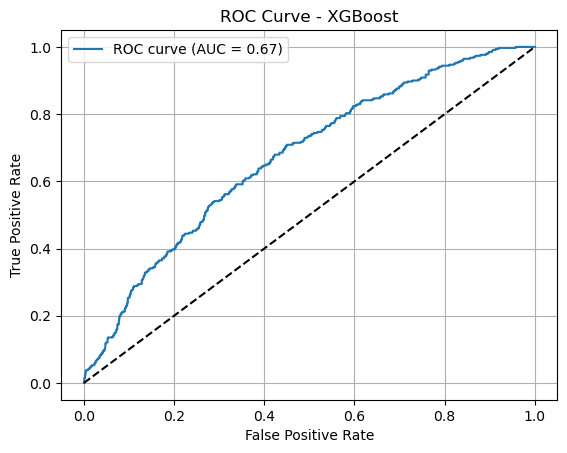

In [239]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix


# Modelin test verisi üzerindeki sınıf olasılıklarını alıyoruz (sadece pozitif sınıf için)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # predict_proba ile sınıf 1 (pozitif sınıf) olasılıklarını al

# AUC (Area Under the Curve) değerini hesapla — modelin ayrıştırma gücünü gösterir
roc_auc = roc_auc_score(y_test, y_pred_proba)

# ROC eğrisi için gerekli olan False Positive Rate (fpr) ve True Positive Rate (tpr) değerlerini al
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# ROC eğrisini çizeriz — yatay eksen: False Positive Rate, dikey eksen: True Positive Rate
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Başarı şansı (random tahmin) için referans çizgisi (45 derece)
plt.plot([0, 1], [0, 1], 'k--')

# Eksen ve başlık ayarları
plt.xlabel('False Positive Rate')  # Yanlış pozitif oranı (1 sınıfına yanlışlıkla atanmış 0 sınıfı örneklerin oranı)
plt.ylabel('True Positive Rate')   # Doğru pozitif oranı (1 sınıfına doğru şekilde atanmış 1 örneklerin oranı)
plt.title('ROC Curve - XGBoost')  # Grafik başlığı

plt.legend()       # Eğri etiketini göster
plt.grid(True)     # Arka plan ızgarasını aç
plt.show()         # Grafiği görüntüle



#### ROC eğrisi, modelin pozitif sınıfı ayırt etme kapasitesini grafiksel olarak gösterir. Modelin ROC AUC değeri 0.67 olarak hesaplanmıştır. Bu, modelin sınıflar arasında %67 oranında doğru ayrım yapabildiğini ve rastgele bir tahminden daha başarılı olduğunu göstermektedir.

## 1. Parametre Arama Aşaması (Grid Search)

In [245]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

#  Model Eğitimi ve En İyinin Seçilmesi
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

##  Tahmin ve Performans Değerlendirme

In [246]:
best_model = grid_search.best_estimator_

# Tahminler
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Metrikler -  Sonuçların Yazdırılması
print("Best Parameters:", grid_search.best_params_) # en olası parametreleri yazdır
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1202
           1       0.40      0.22      0.28       340

    accuracy                           0.76      1542
   macro avg       0.60      0.56      0.57      1542
weighted avg       0.72      0.76      0.73      1542

AUC: 0.666410149750416


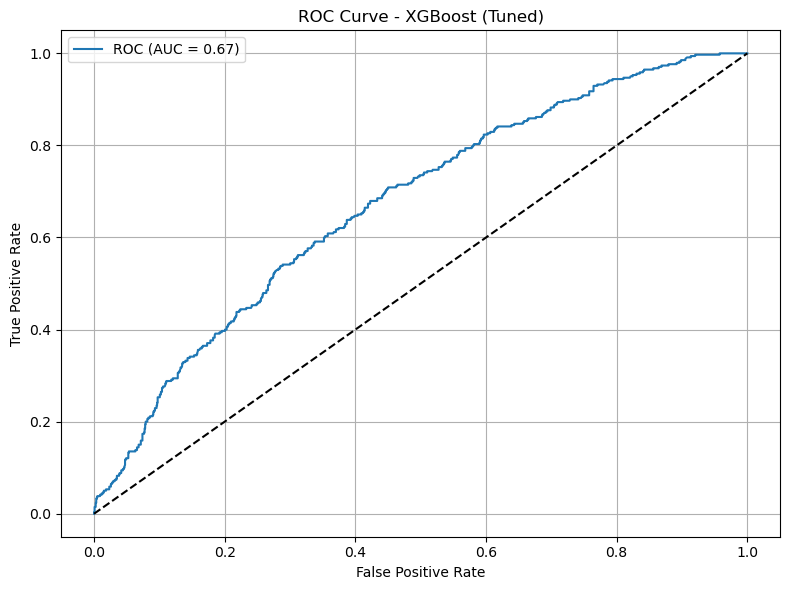

In [244]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (Tuned)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Sonuç
Bu çalışmada, BIST100 verileriyle günlük bazda riskli günlerin sınıflandırılması hedeflenmiştir. Risk tanımı; yüksek sapma, yüksek volatilite ve %1'den büyük günlük değişime göre yapılmıştır.

XGBoostClassifier modeli GridSearchCV ile optimize edilmiş ve en iyi parametrelerle test verisinde şu sonuçlar elde edilmiştir:

Accuracy: 0.76

Riskli sınıf (1) F1-score: 0.28

AUC: 0.67

Model, risksiz günleri başarılı şekilde ayırabilse de, riskli günleri saptamada zayıf kalmıştır. AUC değeri ortalama bir ayrıştırma gücünü göstermektedir.